In [14]:
import os
import platform
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import pathlib
import pickle #to save files
from itertools import product
from scipy.stats import skew, kurtosis, wilcoxon
from scipy.signal import butter, welch, filtfilt, resample
from scipy import stats
# import xgboost as xgb
# from xgboost.sklearn import XGBClassifier #this is the SKlearn wrapper
from sklearn.metrics import confusion_matrix, auc, f1_score, roc_auc_score, precision_score, recall_score, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import svm
import time

from PreprocessFcns import *

from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

sns.set_context('talk',font_scale=1)
#-- For interactive plots--
# from mpl_toolkits.mplot3d import Axes3D
# %matplotlib notebook

## Helper fcns

In [2]:
def LOSOCV(Data,X,y,groups,models,LOin=0):

    subj = LeaveOneGroupOut() 
    results = pd.DataFrame(data=None,columns=['model','f1','auprc','auroc'])
    groupres = {} #results on each group for each model


    #train multiple classifiers
    for m in models:
        acc_all=[]; acc_train=[] 
        f1_test_all=[]; prec_all=[]; rec_all=[]; spec_all=[]; auprc_all=[]; auroc_train_all=[]; 
        auroc_all=[]; fpr_all=[]; tpr_all=[]; fi_all=[]

        clf = m[0]; model_name = m[1]            
        print('Training %s'%model_name)
        s = 0
        #LOSO CV for current classifier
        for train_index, test_index in subj.split(X, y, groups):
        #leave one in:
            if LOin:
                tridx = train_index.copy()
                train_index = test_index.copy()
                test_index = tridx
            Xtr, Xte = X[train_index], X[test_index]
            ytr, yte = y[train_index], y[test_index]
            if len(np.unique(ytr))<2: #skip if no positive or negative examples are available for training
                print('only 1 class available in train data - skipping')
                continue
            clf.fit(Xtr,ytr)
            ypred = clf.predict(Xte)
            yscore = clf.predict_proba(Xte)
            yscore = yscore[:,1]
            
            #accuracy on train set
            ypred_train = clf.predict(Xtr)
            acc_train.append(sum(ypred_train==ytr)/len(ytr))
            auroc_train = roc_auc_score(ytr,clf.predict_proba(Xtr)[:,1])
            
            #f1-score, prec, recall, specificity, auprc, auroc
            f1_test_all.append(f1_score(yte,ypred))
            precision, recall, _ = precision_recall_curve(yte,yscore)
            auprc = auc(recall,precision)
            if len(np.unique(yte))>1:
                auroc = roc_auc_score(yte,yscore)
            else:
                print('only 1 class in test data - cannot compute roc curve')
                auroc = np.nan
            spec = sum((ypred==0) & (yte==0))/sum(yte==0)


            prec_all.append(precision_score(yte,ypred))
            rec_all.append(recall_score(yte,ypred))
            auprc_all.append(auprc)
            auroc_all.append(auroc)
            auroc_train_all.append(auroc_train)
            spec_all.append(spec)
            
            #the recall per task - TO BE COMPLETED
            
#             tasks=Data.iloc[test_index,:].Task
#             for t in tasks.unique():
#                 tasks
            
            #compute ROC points at fixed fpr (to plot error bars)
            fpr=np.linspace(0,1,101); tpr=[]

            if len(np.unique(yte))>1:                
                nscores = np.sort(np.column_stack((yscore[yte==0],yte[yte==0])),axis=0)
                neg_counts = sum(yte==0)
                for f in fpr:
                    ind = neg_counts-int(neg_counts*f)-1
                    t = (nscores[ind])[0]
                    if f==1:
                        t = 0
                    tpr_t = sum(yscore[yte==1]>t) / sum(yte==1)
                    tpr.append(tpr_t) 

            fpr = np.asarray(fpr); tpr = np.asarray(tpr)
            fpr_all.append(fpr); tpr_all.append(tpr)
            
            #store feature importance
            if model_name != 'SVM':
                fi_all.append(clf.feature_importances_)
            
            print('\nSubj/Visit %d, prec=%.3f, rec=%.3f, Spec=%.3f, auroc_train=%.3f, auroc=%.3f'%(s,precision_score(yte,ypred),recall_score(yte,ypred),
                                                                                 spec,auroc_train,auroc))
            s+=1

        print('f1_test=%.3f+/-%.3f, prec=%.3f+/-%.3f, rec=%.3f+/-%.3f, auprc=%.3f+/-%.3f, auroc=%.3f+/-%.3f'%(
        np.nanmean(f1_test_all),np.nanstd(f1_test_all),
        np.nanmean(prec_all),np.nanstd(prec_all), np.nanmean(rec_all),np.nanstd(rec_all),
        np.nanmean(auprc_all),np.nanstd(auprc_all), np.nanmean(auroc_all),np.nanstd(auroc_all)))
        
        #group results for each model
        groupres[model_name] = {'f1':f1_test_all, 'auprc':auprc_all, 'auroc':auroc_all, 'tpr':tpr_all, 'fpr':fpr_all, 
                                'rec':rec_all, 'spec':spec_all, 'fi':fi_all}
        
        #mean across groups for each model
        r = pd.DataFrame({'model':model_name, 'f1':np.nanmean(f1_test_all), 'auprc':np.nanmean(auprc_all), 'auroc':np.nanmean(auroc_all)}
                        ,index=[0])
        results = pd.concat((results,r))
        
    return results,groupres 
    

#train multiple classifiers using stratified kfold
def trainmodel_Kfold(Xf,y,models,nfolds=5,balance=False):

    scaler = StandardScaler()
    f1_fold_clf=[]; auc_fold_clf=[]; cmats={}

    skf = StratifiedKFold(n_splits=nfolds,shuffle=True,random_state=46)
        
    for clf,model_name in models:
        f1_fold = []; f1_train_fold=[]; prec_fold=[]; rec_fold=[]; auprc_fold=[]

        for train_idx,test_idx in skf.split(Xf,y):
            Xtr = Xf[train_idx]
            ytr = y[train_idx]
            if balance:
                #balance dataset
                indsp = np.where(ytr==1)[0]
                indsn = np.random.choice(np.where(ytr==0)[0],size=round(1*len(indsp)),replace=False)
                inds = np.hstack((indsp,indsn))
                Xtr = Xtr[inds]; ytr = ytr[inds]
#             print(len(ytr[ytr==0])/len(ytr[ytr>0]))
            Xte = Xf[test_idx]
            yte = y[test_idx]
            Xtr = scaler.fit_transform(Xtr)
            Xte = scaler.transform(Xte)
            clf.fit(Xtr,ytr)
            ypred_train = clf.predict(Xtr)
            ypred = clf.predict(Xte)
            yscore = clf.predict_proba(Xte)
            yscore = yscore[:,1]
            
            #accuracy on train and test set for current fold
            precision, recall, _ = precision_recall_curve(yte,yscore)
            
            f1_train_fold.append(f1_score(ytr,ypred_train))
            f1_fold.append(f1_score(yte,ypred))
            prec_fold.append(precision_score(yte,ypred))
            rec_fold.append(recall_score(yte,ypred))
            auprc_fold.append(auc(recall,precision)
)


        #mean accuracy across folds
        if balance:
            print('Npos = %d, Nneg = %d'%(len(indsp),len(indsn)))
            
        print('%s'%model_name)
        print('f1_train=%.3f+/-%.3f, f1_test=%.3f+/-%.3f, prec=%.3f+/-%.3f, rec=%.3f+/-%.3f, auprc=%.3f+/-%.3f'%(
        np.nanmean(f1_train_fold),np.nanstd(f1_train_fold),
        np.nanmean(f1_fold),np.nanstd(f1_fold),
        np.nanmean(prec_fold),np.nanstd(prec_fold), np.nanmean(rec_fold),np.nanstd(rec_fold),
        np.nanmean(auprc_fold),np.nanstd(auprc_fold)))
        
        cf_matrix = confusion_matrix(yte, ypred)
        print(cf_matrix)
        #store f1 and auc for each fold and clf
        f1_fold_clf.append(f1_fold)
        auc_fold_clf.append(auprc_fold)
        #store cmat for each clf (on last fold)
        cmats.update({model_name:cf_matrix})
        
    return f1_fold_clf, auc_fold_clf, cmats

    
    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    

def plot_roc(tpr_all,fpr,roc_auc,ax=None,plotname=None,col=None):
    #plot mean ROC across subjects (need to add shaded conf interval)
    tprmu = np.mean(np.asarray(tpr_all),axis=0)
    tpr=np.asarray(tpr_all)
    fpr=np.reshape(fpr,(1,-1))
    tprmu=np.reshape(tprmu,(1,-1))
    label=pd.Series(data = ['%s - AUC = %0.3f' % (plotname,roc_auc)]*len(fpr))
    if plotname=='Threshold':
        ls = '-'
    else:
        ls='-'
    if ax == None:
        ax = sns.tsplot(data=tpr,time=fpr,ci=95,condition=label,legend=True,color=col,lw=3,linestyle=ls)
    else:
        sns.tsplot(data=tpr,time=fpr,ci=95,condition=label, legend=True,ax=ax,color=col,lw=3,linestyle=ls)
             
    lw = 3
    
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax.set_xlim([-0.05, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate',fontsize=16)
    ax.set_ylabel('True Positive Rate',fontsize=16)
    ax.legend(loc='lower right')
    
    return ax

def LOSOCV_Tasks(Data,X,y,groups,tasks,clf):

    subj = LeaveOneGroupOut() 
    results = pd.DataFrame(data=None,columns=['model','f1','auprc','auroc'])
    groupres = {} #results on each group for each task subset


    #train multiple classifiers
    for T in tasks:
        acc_all=[]; acc_train=[] 
        f1_test_all=[]; prec_all=[]; rec_all=[]; spec_all=[]; auprc_all=[]; auroc_train_all=[]; 
        auroc_all=[]; fpr_all=[]; tpr_all=[]; fi_all=[]
          
        s = 0
        #LOSO CV for current classifier
        for train_index, test_index in subj.split(X, y, groups):
            task_inds = Data.Task.iloc[test_index]==T[0]
            for Ti in T[1::]:
                task_inds = task_inds | (Data.Task.iloc[test_index]==Ti)
            test_index = test_index[task_inds]
            Xtr, Xte = X[train_index], X[test_index]
            ytr, yte = y[train_index], y[test_index]
            if len(np.unique(ytr))<2: #skip if no positive or negative examples are available for training
                print('only 1 class available in train data - skipping')
                continue
            clf.fit(Xtr,ytr)
            ypred = clf.predict(Xte)
            yscore = clf.predict_proba(Xte)
            yscore = yscore[:,1]

            #accuracy on train set
            ypred_train = clf.predict(Xtr)
            acc_train.append(sum(ypred_train==ytr)/len(ytr))
            auroc_train = roc_auc_score(ytr,clf.predict_proba(Xtr)[:,1])

            #f1-score, prec, recall, specificity, auprc, auroc
            f1_test_all.append(f1_score(yte,ypred))
            precision, recall, _ = precision_recall_curve(yte,yscore)
            auprc = auc(recall,precision)
            if len(np.unique(yte))>1:
                auroc = roc_auc_score(yte,yscore)
            else:
                print('only 1 class in test data - cannot compute roc curve')
                auroc = np.nan
            spec = sum((ypred==0) & (yte==0))/sum(yte==0)


            prec_all.append(precision_score(yte,ypred))
            rec_all.append(recall_score(yte,ypred))
            auprc_all.append(auprc)
            auroc_all.append(auroc)
            auroc_train_all.append(auroc_train)
            spec_all.append(spec)

            #the recall per task - TO BE COMPLETED

#             tasks=Data.iloc[test_index,:].Task
#             for t in tasks.unique():
#                 tasks

            #compute ROC points at fixed fpr (to plot error bars)
            fpr=np.linspace(0,1,101); tpr=[]

            if len(np.unique(yte))>1:                
                nscores = np.sort(np.column_stack((yscore[yte==0],yte[yte==0])),axis=0)
                neg_counts = sum(yte==0)
                for f in fpr:
                    ind = neg_counts-int(neg_counts*f)-1
                    t = (nscores[ind])[0]
                    if f==1:
                        t = 0
                    tpr_t = sum(yscore[yte==1]>t) / sum(yte==1)
                    tpr.append(tpr_t) 

            fpr = np.asarray(fpr); tpr = np.asarray(tpr)
            fpr_all.append(fpr); tpr_all.append(tpr)

            #store feature importance
            if model_name != 'SVM':
                fi_all.append(clf.feature_importances_)

            s+=1

        #group results for each model
        groupres[tuple(T)] = {'f1':f1_test_all, 'auprc':auprc_all, 'auroc':auroc_all, 'tpr':tpr_all, 'fpr':fpr_all, 
                                'rec':rec_all, 'spec':spec_all, 'fi':fi_all}

        #mean across groups for each model
        r = pd.DataFrame({'model':model_name, 'f1':np.nanmean(f1_test_all), 'auprc':np.nanmean(auprc_all), 'auroc':np.nanmean(auroc_all)}
                        ,index=[0])
        results = pd.concat((results,r))
        
    return results,groupres 
    

In [3]:
from sklearn.model_selection import LeaveOneGroupOut
from sklearn import preprocessing
from sklearn import neighbors, linear_model
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.linear_model import ElasticNetCV, LogisticRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix

In [8]:
# path = r'D:\CIS-PD Study\Subjects' #Windows remote path
# folder_path = r'D:\CIS-PD Study' #generic Windows repo path
# dict_path = 'D:\CIS-PD Study\Data_dict'
# scores_path = r'D:\CIS-PD Study\Scores' #remote repo
# features_path = r'D:\CIS-PD Study\FeatureMatrix' #remote repo
# results_path = r'C:\Users\andre\Documents\GitHub\CIS_PD\Results' #results folder

path = '/Volumes/RTO/CIS-PD Study/Subjects/' #Mac
folder_path = '/Volumes/RTO/CIS-PD Study/'
dict_path = '../Data_dict' # Mac local path
scores_path = '../Scores/' # Mac local path
features_path = '../FeatureMatrix' # Mac local path
results_path = './Results' # Mac local path

# # #---------------------------------------------------------------------------------------------------------
# # # Set path to folder containing Subject ID numbers
# # # path = '/Volumes/RTO/CIS-PD Study/Subjects/' #Mac
# path = r'Y:\CIS-PD Study\Subjects' #Windows local path adai
# # #---------------------------------------------------------------------------------------------------------
# # #Path where dictionary subject data is stored
# dict_path = 'Y:\CIS-PD Study\Data_dict' #remote repo
# # # dict_path = '../Data_dict' #local path
# # # dict_path = r'C:\Users\adai\Documents\Data_dict' #Windows local path adai

# scores_path = r'Y:\CIS-PD Study\Scores' #remote repo
# # # scores_path = '../Scores/' #local path

# # #path where feature matrix is saved
# # # features_path = '../FeatureMatrix' #local
# features_path = 'Y:\CIS-PD Study\FeatureMatrix'

## Load unpacked features data

In [6]:
# filename = 'Features_AllLocsHP+LP_Hand.pkl'
filename = 'Features_AllLocsHP_Hand.pkl'
Data = pickle.load(open(os.path.join(features_path,filename),'rb'))
Data = Data.reset_index(drop=True)
print(Data.shape)

(42100, 81)


In [7]:
Data.head(2)

,Subject,Visit,Side,Task,Tremor,Bradykinesia,Dyskinesia,RMSXacc,RMSYacc,RMSZacc,...,PSD_stdgyr,PSD_skewgyr,PSD_kurgyr,jerk_meangyr,jerk_stdgyr,jerk_skewgyr,jerk_kurgyr,Sen_Xgyr,Sen_Ygyr,Sen_Zgyr
0,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,0.008648,0.010949,0.007293,...,333.369231,3.587466,15.204802,0.114246,10.726893,0.176444,-0.009173,0.416625,0.571324,0.438326
1,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,0.008127,0.010331,0.007008,...,511.580241,4.261274,17.609498,-0.173831,10.278264,0.551148,0.059904,0.321724,0.525199,0.307797


In [8]:
#drop features 
Data=Data.drop(labels=['RMSXacc','RMSYacc','RMSZacc'],axis=1)    #equivalent to variance if mean 0
Data=Data.drop(labels=['meanXacc','meanYacc','meanZacc'],axis=1) #if signal is mean 0 this feature is useless
Data=Data.drop(labels=['varXacc','varYacc','varZacc'],axis=1) #range is strongly correlated with variance
Data=Data.drop(labels=['RMSXgyr','RMSYgyr','RMSZgyr'],axis=1)    #equivalent to variance if mean 0
Data=Data.drop(labels=['meanXgyr','meanYgyr','meanZgyr'],axis=1) #if signal is mean 0 this feature is useless
Data=Data.drop(labels=['varXgyr','varYgyr','varZgyr'],axis=1) #range is strongly correlated with variance

In [9]:
# #drop features 
# Data=Data.drop(labels=['RMSXacc_dorsal_hand_','RMSYacc_dorsal_hand_','RMSZacc_dorsal_hand_'],axis=1)    #equivalent to variance if mean 0
# Data=Data.drop(labels=['meanXacc_dorsal_hand_','meanYacc_dorsal_hand_','meanZacc_dorsal_hand_'],axis=1) #if signal is mean 0 this feature is useless
# Data=Data.drop(labels=['varXacc_dorsal_hand_','varYacc_dorsal_hand_','varZacc_dorsal_hand_'],axis=1) #range is strongly correlated with variance
# Data=Data.drop(labels=['RMSXgyr_dorsal_hand_','RMSYgyr_dorsal_hand_','RMSZgyr_dorsal_hand_'],axis=1)    #equivalent to variance if mean 0
# Data=Data.drop(labels=['meanXgyr_dorsal_hand_','meanYgyr_dorsal_hand_','meanZgyr_dorsal_hand_'],axis=1) #if signal is mean 0 this feature is useless
# Data=Data.drop(labels=['varXgyr_dorsal_hand_','varYgyr_dorsal_hand_','varZgyr_dorsal_hand_'],axis=1) #range is strongly correlated with variance

In [10]:
Data=Data[Data.Subject!=1020] #remove subj does not have visits 1-5

In [11]:
Dataorig = Data.copy()
Data.shape

(40377, 63)

In [12]:
Data.Task.unique()

array(['Motor #2: Walking', 'Motor #3: Walking while Counting',
       'Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements',
       'Motor #6: Sit to Stand', 'Motor #7: Drawing on Paper',
       'Motor #8: Typing on a Computer', 'Motor #9: Nuts and Bolts',
       'Motor #10: Drinking Water', 'Motor #11: Organizing Folder',
       'Motor #12: Folding Towels', 'Motor #1: Standing',
       'Motor #13: Sitting'], dtype=object)

## LOSO CV - ALL TASKS

## Bradykinesia

In [13]:
# #amount of data per subject
# subjdata=[]
# for s in Data.Subject.unique():
# #     print(s,len(Data[Data.Subject==s]))
#     subjdata.append(len(Data[Data.Subject==s]))
    
# sns.barplot(Data.Subject.unique(),subjdata)
# ax=plt.xticks(rotation=90)

In [14]:
Dataorig = Data.copy()

In [12]:
Dataorig[symptom].unique()

NameError: name 'symptom' is not defined

In [13]:
Data[symptom].unique()

NameError: name 'symptom' is not defined

In [ ]:
t1=time.time()
res_all = pd.DataFrame()

Data=Data.reset_index(drop=True) #reset index

for symptom in ['Bradykinesia']:
    
    #remove nan rows for current symptom
    Data = Dataorig.copy() #original unmodified dataframe
    Data=Data[~Data[symptom].isnull()]
    Data=Data.reset_index(drop=True) #reset index
    
    X = Data.iloc[:,7:].as_matrix()
    # X = StandardScaler().fit_transform(X)
    fnames = Data.iloc[:,7:].columns.values

    indp = ((Data[symptom]>0))
    indp = indp.values
    y = indp.astype(int) #target 
    print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

    models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
#           XGBClassifier()]
    model_name = ['Random Forest']#,'XGB']
    models = list(zip(models,model_name))
    groups = Data.Subject.as_matrix()

    res,res_group = LOSOCV(Data,X,y,groups,models)
    res_all = pd.concat((res_all,res))
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

In [ ]:
resultsbrady = res_group['Random Forest']['auroc']

In [ ]:
np.save('./Results/resultsbradyLOSO.npy',resultsbrady)

In [ ]:
np.unique(groups)

Removing nans

In [ ]:
aurocall = res_group['Random Forest']['auroc']
sns.barplot(np.unique(groups),aurocall) #to show subj codes
ax=plt.xticks(rotation=90)
# sns.barplot(np.arange(len(aurocall)),aurocall) #to show subj codes
plt.ylim([0.45,1.])
plt.title('LOSO - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))

In [ ]:
plot_roc(res_group['Random Forest']['tpr'],res_group['Random Forest']['fpr'][0],np.mean(res_group['Random Forest']['auroc']))

### Tremor

In [ ]:
t1=time.time()
res_all = pd.DataFrame()

Data=Data.reset_index(drop=True) #reset index

for symptom in ['Tremor']:
    
    #remove nan rows for current symptom
    Data = Dataorig.copy() #original unmodified dataframe
    Data=Data[~Data[symptom].isnull()]
    Data=Data.reset_index(drop=True) #reset index
    
    X = Data.iloc[:,7:].as_matrix()
    # X = StandardScaler().fit_transform(X)
    fnames = Data.iloc[:,7:].columns.values

    indp = ((Data[symptom]>0))
    indp = indp.values
    y = indp.astype(int) #target 
    print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

    models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
#           XGBClassifier()]
    model_name = ['Random Forest']#,'XGB']
    models = list(zip(models,model_name))
    groups = Data.Subject.as_matrix()

    res,res_group = LOSOCV(Data,X,y,groups,models)
    res_all = pd.concat((res_all,res))
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

In [ ]:
resultstremor = res_group['Random Forest']['auroc']

In [ ]:
np.save('./Results/resultstremorLOSO.npy',resultstremor)

Removing nans

In [ ]:
aurocall = res_group['Random Forest']['auroc']
sns.barplot(np.unique(groups),aurocall) #to show subj codes
ax=plt.xticks(rotation=90)
# sns.barplot(np.arange(len(aurocall)),aurocall) #to show subj codes
plt.ylim([0.45,1.])
plt.title('LOSO - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(aurocall),np.nanstd(aurocall)))

## Personal Models

In [ ]:
symptom = 'Bradykinesia'
le = LabelEncoder()
res_all = pd.DataFrame(data=None,index=None)
#train on all sessions, predict on left out session for each patient
res_visit_all = [] #data from each subject 

#remove nan rows for current symptom
Data = Dataorig.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()]
Data=Data.reset_index(drop=True) #reset index

for s in Data.Subject.unique():
    print('Subject %s'%s)
    ds = Data.loc[Data.Subject==s]
    indp = (ds[symptom]>0).values
    y = indp.astype(int) #target 
    X = ds.iloc[:,7:]
    X_std = StandardScaler().fit_transform(X) #standardize input data
    models = [RandomForestClassifier(n_estimators=50,random_state=2)]#,XGBClassifier()]
    model_name = ['Random Forest']#,'XGB']
    models = list(zip(models,model_name))
    groups = le.fit_transform(ds.Visit)
    if len(np.unique(groups))<2:
        continue
    res,res_group = LOSOCV(ds,X_std,y,groups,models)
    res.index = res.index+s
    res_all=pd.concat((res_all,res))
    res_visit_all.append(res_group)


In [ ]:
resultsbrady_pers=res_all.auroc.values
np.save('./Results/resultsbradyPERS.npy',resultsbrady_pers)

In [ ]:
Data.shape

In [ ]:
#compute mean and std auc
subjs=Data.Subject.unique()
auc_mean = []; auc_std = []
aucdf = pd.DataFrame()
for i in range(len(res_visit_all)):

    if len(res_visit_all[i]['Random Forest']['auroc']) < 7:
        res_visit_all[i]['Random Forest']['auroc'].append(np.nan)
    aucdf[subjs[i]] = res_visit_all[i]['Random Forest']['auroc']   
    auc = res_visit_all[i]['Random Forest']['auroc']
    auc_mean.append(np.nanmean(auc)) #mean across visits
    auc_std.append(np.nanstd(auc))

In [ ]:
sns.barplot(data=aucdf)
ax=plt.xticks(rotation=90)
plt.title('LOVO - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(res_all.auroc),np.nanstd(res_all.auroc)))
plt.ylim([0.45,1])

Is variability due to variability in symptoms between visits?

### Tremor

In [ ]:
symptom = 'Tremor'
le = LabelEncoder()
res_all = pd.DataFrame(data=None,index=None)
#train on all sessions, predict on left out session for each patient
res_visit_all = [] #data from each subject 

#remove nan rows for current symptom
Data = Dataorig.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()]
Data=Data.reset_index(drop=True) #reset index

for s in Data.Subject.unique():
    print('Subject %s'%s)
    ds = Data.loc[Data.Subject==s]
    indp = (ds[symptom]>0).values
    y = indp.astype(int) #target 
    X = ds.iloc[:,7:]
    X_std = StandardScaler().fit_transform(X) #standardize input data
    models = [RandomForestClassifier(n_estimators=50,random_state=2)]#,XGBClassifier()]
    model_name = ['Random Forest']#,'XGB']
    models = list(zip(models,model_name))
    groups = le.fit_transform(ds.Visit)
    if len(np.unique(groups))<2:
        continue
    res,res_group = LOSOCV(ds,X_std,y,groups,models)
    res.index = res.index+s
    res_all=pd.concat((res_all,res))
    res_visit_all.append(res_group)


In [ ]:
resultstremor_pers=res_all.auroc.values
np.save('./Results/resultstremorPERS.npy',resultstremor_pers)

In [ ]:
#compute mean and std auc
subjs=Data.Subject.unique()
auc_mean = []; auc_std = []
aucdf = pd.DataFrame()
for i in range(len(res_visit_all)):

    if len(res_visit_all[i]['Random Forest']['auroc']) < 7:
        L = len(res_visit_all[i]['Random Forest']['auroc'])
        res_visit_all[i]['Random Forest']['auroc'] += (list(np.nan*np.ones(7-L)))
    aucdf[subjs[i]] = res_visit_all[i]['Random Forest']['auroc']   
    auc = res_visit_all[i]['Random Forest']['auroc']
    auc_mean.append(np.nanmean(auc)) #mean across visits
    auc_std.append(np.nanstd(auc))

In [ ]:
sns.barplot(data=aucdf)
ax=plt.xticks(rotation=90)
plt.title('LOVO - Mean AUROC = %.3f +/- %.3f'%(np.nanmean(res_all.auroc),np.nanstd(res_all.auroc)))
plt.ylim([0.45,1.])

## Box plots comparing global and personal

In [9]:
resultstremor = np.load(os.path.join(results_path,'resultstremorLOSO.npy'))
resultsbrady = np.load(os.path.join(results_path,'resultsbradyLOSO.npy'))

In [10]:
resultsbrady_pers=np.load(os.path.join(results_path,'resultsbradyPERS.npy'))
resultstremor_pers=np.load(os.path.join(results_path,'resultstremorPERS.npy'))

In [7]:
len(resultstremor)

19

In [11]:
results = pd.DataFrame({'Population-Bradykinesia':resultsbrady, 'Personal-Bradykinesia':resultsbrady_pers,
             'Population-Tremor':resultstremor, 'Personal-Tremor':resultstremor_pers})

In [13]:
results

,Personal-Bradykinesia,Personal-Tremor,Population-Bradykinesia,Population-Tremor
0,0.767547,0.789604,0.732459,0.817951
1,0.961460,0.945532,0.765131,0.762198
2,0.876756,0.922093,0.797327,0.823991
3,0.927650,0.872331,0.855111,0.719815
4,0.844759,0.832880,0.748970,0.675224
5,0.830516,0.834678,0.549812,0.741891
6,0.882630,0.966710,0.783807,0.915046
7,0.865396,0.914523,0.549381,0.912006
8,0.822025,0.878114,0.583525,0.785081
9,0.920347,0.995063,0.776677,0.896676


In [9]:
brady_data = results[['Population-Bradykinesia','Personal-Bradykinesia']]

In [10]:
stats.ttest_rel(results['Personal-Bradykinesia'].values,results['Population-Bradykinesia'].values)

Ttest_relResult(statistic=6.7761034917453715, pvalue=2.392890207441125e-06)

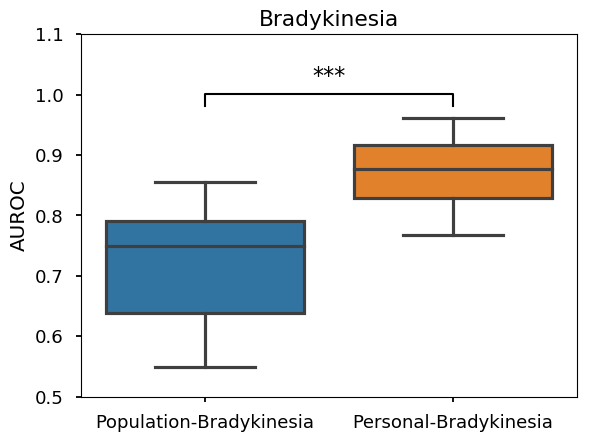

In [11]:
figure = plt.figure()
figure.set_dpi(100)
figure.set_size_inches(6.4,4.8)
ax = sns.boxplot(data=brady_data);
plt.ylabel('AUROC');
plt.ylim(0.5,1.1);
plt.title('Bradykinesia');

x1,x2 = 0,1
y, h, col = brady_data['Personal-Bradykinesia'].max() + 0.02, 0.02, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h+0.01, "***", ha='center', va='bottom', color=col,fontsize=16);

plt.savefig('Bradykinesia Comparison Boxplot.png',format='png',dpi=1000)
plt.savefig('Bradykinesia Comparison Boxplot.tiff',format='tiff', dpi=1000)

In [12]:
tremor_data = results[['Population-Tremor','Personal-Tremor']]

In [13]:
stats.ttest_rel(results['Personal-Tremor'][~results['Personal-Tremor'].isnull()].values,
                results['Population-Tremor'][~results['Personal-Tremor'].isnull()].values)

Ttest_relResult(statistic=4.494092565323346, pvalue=0.00042831179045540416)

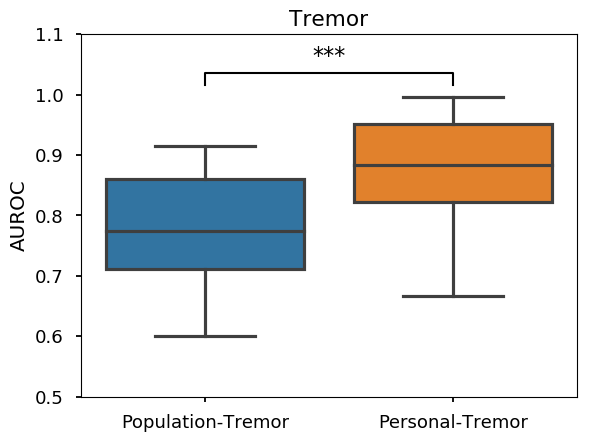

In [14]:
figure = plt.figure()
figure.set_dpi(100)
figure.set_size_inches(6.4,4.8)
ax = sns.boxplot(data=tremor_data);
plt.ylabel('AUROC');
plt.ylim(0.5,1.1);
plt.title('Tremor')

x1,x2 = 0,1
y, h, col = tremor_data['Personal-Tremor'].max() + 0.02, 0.02, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h+0.01, "***", ha='center', va='bottom', color=col,fontsize=16);

plt.savefig('Tremor Comparison Boxplot.png',format='png',dpi=1000)
plt.savefig('Tremor Comparison Boxplot.tiff',format='tiff',dpi=1000)

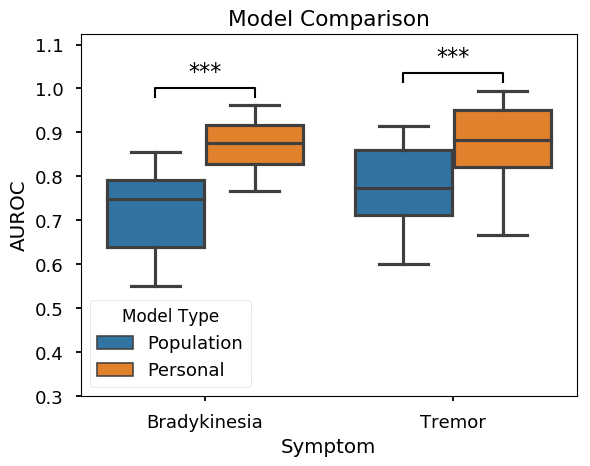

In [17]:
pop1 = brady_data['Population-Bradykinesia']; pop2 = tremor_data['Population-Tremor'];
per1 = brady_data['Personal-Bradykinesia']; per2 = tremor_data['Personal-Tremor'];

g1 = np.shape(pop1)[0]*['Bradykinesia']
g2 = np.shape(pop2)[0]*['Tremor']
df = pd.DataFrame.from_dict({'Symptom':(g1 + g2),'Population':(list(pop1) + list(pop2)),'Personal':(list(per1) + list(per2))})
df_new = pd.melt(df,id_vars=['Symptom'],value_vars=['Population','Personal'],var_name=['Model Type']);

figure = plt.figure();
figure.set_dpi(100);
figure.set_size_inches(6.4,4.8);
ax = sns.boxplot(x='Symptom',y='value',data=df_new,hue='Model Type');

x1,x2 = -0.2,0.2
y, h, col = brady_data['Personal-Bradykinesia'].max() + 0.02, 0.02, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h+0.01, "***", ha='center', va='bottom', color=col,fontsize=16);

x3,x4 = 0.8,1.2
y, h, col = tremor_data['Personal-Tremor'].max() + 0.02, 0.02, 'k'
plt.plot([x3, x3, x4, x4], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x3+x4)*.5, y+h+0.01, "***", ha='center', va='bottom', color=col,fontsize=16);

plt.ylim(0.3,1.125)
plt.ylabel('AUROC');
plt.title('Model Comparison')
plt.savefig('Model Comparison.png',format='png',dpi=1000)
plt.savefig('Model Comparison.tiff',format='tiff',dpi=1000)

(array([1, 2, 3, 4]), <a list of 4 Text xticklabel objects>)

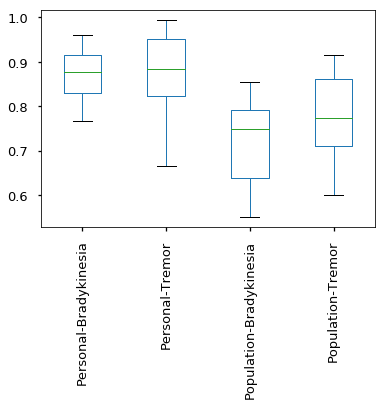

In [16]:
results.plot(kind='box')
plt.xticks(rotation=90)

## Evaluate performance of global models on Subtasks (this section has to be rewritten to train global and personal models on all tasks and analyze performance on each subset of tasks)

In [12]:
from scipy import stats
def save_object(obj, filename):
    with open(filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)

In [13]:
Dataorig = Data.copy()
taskA = ['Motor #4: Finger to Nose','Motor #5: Alternating Hand Movements']
taskB = ['Motor #2: Walking', 'Motor #3: Walking while Counting']
taskB1 = ['Motor #1: Standing','Motor #13: Sitting'] #tremor
taskC = ['Motor #10: Drinking Water','Motor #11: Organizing Folder','Motor #12: Folding Towels']
taskD = ['Motor #7: Drawing on Paper','Motor #8: Typing on a Computer', 'Motor #9: Nuts and Bolts',]
tasks = [taskA,taskB+taskB1,taskC,taskD]
tasks = tasks# + [list(np.concatenate(tasks))]

Rows w Tremor 8879/38405 = 0.23


C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve


C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve


C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve


C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve


C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve


C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve


C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve


C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve


C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve


C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve


C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve


C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve


C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve


C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve


C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve


C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve


C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve


C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve


C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve


C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve


C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve


C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve


C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve


C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve


C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve


C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve
Clinical 0.7254522705795429 (0.645481352377457, 0.8054231887816288)
Walking 0.6817116654214878 (0.45570259358973775, 0.9077207372532378)


C:\Users\andre\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


Gross Motor 0.5688706557060916 (0.5083018179980237, 0.6294394934141596)
Fine Motor 0.702510620199436 (0.6031355974062202, 0.8018856429926517)
Elapsed time = 15.996 min


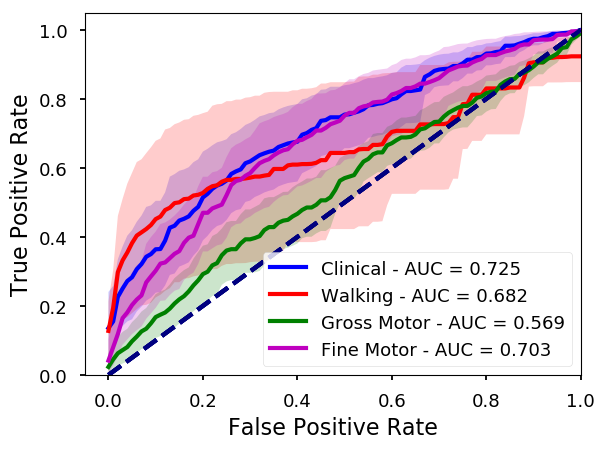

In [14]:
# Global Models
t1=time.time()
res_all = pd.DataFrame()

Data=Data.reset_index(drop=True) #reset index
ind=1

# for symptom in ['Bradykinesia']:
for symptom in ['Tremor']:
    
    #remove nan rows for current symptom
    Data = Dataorig.copy() #original unmodified dataframe
    Data=Data[~Data[symptom].isnull()]
    Data=Data.reset_index(drop=True) #reset index
    
    X = Data.iloc[:,7:].as_matrix()
    # X = StandardScaler().fit_transform(X)
    fnames = Data.iloc[:,7:].columns.values

    indp = ((Data[symptom]>0))
    indp = indp.values
    y = indp.astype(int) #target 
    print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

    models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
#           XGBClassifier()]
    model_name = ['Random Forest']#,'XGB']
    models = list(zip(models,model_name))
    groups = Data.Subject.as_matrix()

    res,res_group = LOSOCV_Tasks(Data,X,y,groups,tasks,models[0][0])
    res_all = pd.concat((res_all,res))
    
    Tasks = list(res_group.keys())
    AX=None
#     plt.figure(figsize=(9,6))

    figure = plt.figure()
    figure.set_dpi(100)
    figure.set_size_inches(6.4,4.8)
    
    cols = ['b','r','g','m','k']
    TaskNames = ['Clinical', 'Walking', 'Gross Motor', 'Fine Motor', 'All']
    for x,T in zip(range(len(Tasks)),Tasks):
        NanInds = []
        for i in range(len(res_group[T]['auroc'])):
            if np.isnan(res_group[T]['auroc'][i]):
                NanInds.append(i)
        for i in sorted(NanInds,reverse=True):
            del res_group[T]['tpr'][i]
            del res_group[T]['auroc'][i]
            
        AUC = res_group[T]['auroc']
        print(TaskNames[x],np.mean(AUC),
              stats.t.interval(.95,len(AUC)-1, loc=np.mean(AUC), scale=stats.sem(AUC)))
            
        if AX==None:
            AX = plot_roc(res_group[T]['tpr'],res_group[T]['fpr'][0],np.mean(res_group[T]['auroc']),plotname=TaskNames[x],col = cols[x])
        else:
            plot_roc(res_group[T]['tpr'],res_group[T]['fpr'][0],np.mean(res_group[T]['auroc']),plotname=TaskNames[x],ax=AX,col=cols[x])
    
    save_object(res_group,symptom+'DataResults')
    plt.savefig(symptom+'Tasks.tiff',format='tiff',dpi=1000)
    plt.savefig(symptom+'Tasks.png',format='png',dpi=1000)
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))  

In [ ]:
file.close()

In [35]:
with open('BradykinesiaDataResults','rb') as file:
    BradykinesiaRes = pickle.load(file)
    
# with open('TremorDataResults','rb') as file:
#     TremorRes = pickle.load(file)

In [36]:
for k in BradykinesiaRes.keys():
    print(k)
    try:
        print(stats.ttest_ind(BradykinesiaRes[('Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements')]['auroc'],
                              BradykinesiaRes[k]['auroc']))
    except:
        continue

('Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements')
Ttest_indResult(statistic=0.0, pvalue=1.0)
('Motor #2: Walking', 'Motor #3: Walking while Counting', 'Motor #1: Standing', 'Motor #13: Sitting')
Ttest_indResult(statistic=-0.6186182201885729, pvalue=0.5405467883012931)
('Motor #10: Drinking Water', 'Motor #11: Organizing Folder', 'Motor #12: Folding Towels')
Ttest_indResult(statistic=1.61336345178503, pvalue=0.11713683600421766)
('Motor #7: Drawing on Paper', 'Motor #8: Typing on a Computer', 'Motor #9: Nuts and Bolts')
Ttest_indResult(statistic=-0.9733509825919716, pvalue=0.3374600719691072)


In [ ]:
for k in TremorRes.keys():
    print(k)
    try:
        print(stats.ttest_ind(TremorRes[('Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements')]['auroc'],
                              TremorRes[k]['auroc']))
    except:
        continue

In [ ]:
save_object(res_group,symptom+'DataResults')
plt.savefig(symptom+'Tasks.svg')
plt.savefig(symptom+'Tasks.png')

Rows w Bradykinesia 16574/32368 = 0.51
only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if 

only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve
only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve
only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:317: RuntimeWarning: Mean of empty slice


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve
only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve
only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve
only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve
only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:317: RuntimeWarning: Mean of empty slice


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:317: RuntimeWarning: Mean of empty slice


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', ave

only 1 class in test data - cannot compute roc curve
only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:317: RuntimeWarning: Mean of empty slice
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve
only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve
only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve
only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve
only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve
only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall 

only 1 class in test data - cannot compute roc curve
only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being s

only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\l

only 1 class in test data - cannot compute roc curve
only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve
only 1 class in test data - cannot compute roc curve
only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:317: RuntimeWarning: Mean of empty slice
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMe

only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\

only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', ave

only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve
only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being s

only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve
only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve
only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve
only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve
only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve
only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:317: RuntimeWarning: Mean of empty slice


only 1 class in test data - cannot compute roc curve
only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:44

only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve
only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve
only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:317: RuntimeWarning: Mean of empty slice


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:317: RuntimeWarning: Mean of empty slice


only 1 class in test data - cannot compute roc curve


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:273: RuntimeWarning: invalid value encountered in long_scalars


Clinical 0.8735247548054149 (0.7981789902272396, 0.9488705193835902)
Walking 0.7779524743115989 (0.6644896801300136, 0.8914152684931841)


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


Gross Motor 0.6961858206334187 (0.6137415473364669, 0.7786300939303705)
Fine Motor 0.8667754771775347 (0.8222353470649296, 0.9113156072901397)
Elapsed time = 2.439 min


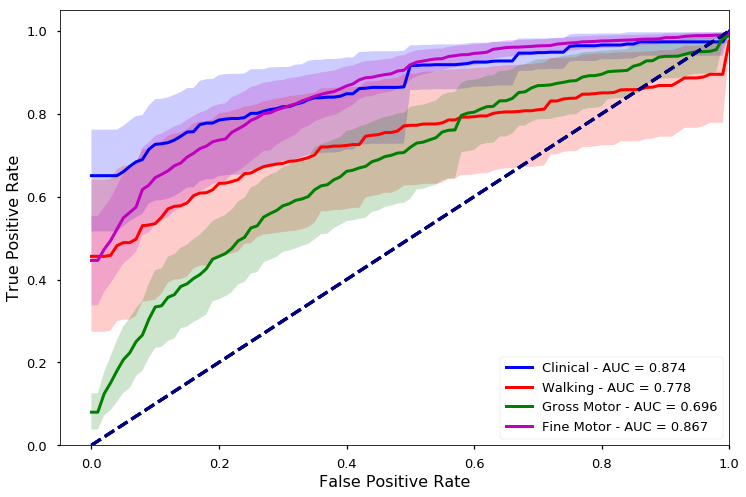

In [33]:
# Personal Models
t1=time.time()
res_all = pd.DataFrame()
le = LabelEncoder()
Data=Data.reset_index(drop=True) #reset index

for symptom in ['Bradykinesia']:#, 'Tremor']:
    
    res_allvisits = {}
    for T in tasks:
        res_allvisits[tuple(T)] = {'tpr':[],'fpr':[],'auroc':[]}
    
    #remove nan rows for current symptom
    Data = Dataorig.copy() #original unmodified dataframe
    Data=Data[~Data[symptom].isnull()]
    Data=Data.reset_index(drop=True) #reset index
    
    X = Data.iloc[:,7:].as_matrix()
    # X = StandardScaler().fit_transform(X)
    fnames = Data.iloc[:,7:].columns.values

    indp = ((Data[symptom]>0))
    indp = indp.values
    y = indp.astype(int) #target 
    print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

    for s in Data.Subject.unique():
        ds = Data.loc[Data.Subject==s]
        indp = (ds[symptom]>0).values
        y = indp.astype(int) #target 
        X = ds.iloc[:,7:]
        X_std = StandardScaler().fit_transform(X) #standardize input data
        groups = le.fit_transform(ds.Visit)
        if len(np.unique(groups))<2:
            continue
        

        models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
        model_name = ['Random Forest']
        models = list(zip(models,model_name))

        res,res_group = LOSOCV_Tasks(ds,X_std,y,groups,tasks,models[0][0])
        
        #loop through visits and remove NaNs
        for T in res_group.keys():
            NanInds = []
            for i in range(len(res_group[T]['auroc'])):
                if np.isnan(res_group[T]['auroc'][i]):
                    NanInds.append(i)
            for i in sorted(NanInds,reverse=True):
                del res_group[T]['tpr'][i]
                del res_group[T]['auroc'][i]
            if len(res_group[T]['auroc'])>0:
                res_allvisits[T]['tpr'].append(np.nanmean(res_group[T]['tpr'],axis=0))
                res_allvisits[T]['fpr'].append(np.nanmean(res_group[T]['fpr'],axis=0))
                res_allvisits[T]['auroc'].append(np.nanmean(res_group[T]['auroc']))
        
    Tasks = list(res_group.keys())
    AX=None
#     plt.figure(figsize=(9,6))

    figure = plt.figure()
    figure.set_dpi(100)
    figure.set_size_inches(6.4,4.8)
    
    cols = ['b','r','g','m','k']
    TaskNames = ['Clinical', 'Walking', 'Gross Motor', 'Fine Motor', 'All']
    for x,T in zip(range(len(Tasks)),Tasks):
        
        AUC = res_allvisits[T]['auroc']
        print(TaskNames[x],np.mean(AUC),
              stats.t.interval(.95,len(AUC)-1, loc=np.mean(AUC), scale=stats.sem(AUC)))
        
        if AX==None:
            AX = plot_roc(res_allvisits[T]['tpr'],res_allvisits[T]['fpr'][0],np.mean(res_allvisits[T]['auroc']),
                          plotname=TaskNames[x],col = cols[x])
        else:
            plot_roc(res_allvisits[T]['tpr'],res_allvisits[T]['fpr'][0],np.mean(res_allvisits[T]['auroc']),
                     plotname=TaskNames[x],ax=AX,col=cols[x])

    save_object(res_allvisits,symptom+'PersonalDataResults')
    plt.savefig(symptom+'Tasks.jpg')
    plt.savefig(symptom+'Tasks.png',format='png',dpi=1000)
    

print('Elapsed time = %.3f min'%((time.time()-t1)/60))  

In [37]:
with open('BradykinesiaPersonalDataResults','rb') as file:
    BradykinesiaRes = pickle.load(file)
    
# with open('TremorPersonalDataResults','rb') as file:
#     TremorRes = pickle.load(file)

In [38]:
for k in BradykinesiaRes.keys():
    print(k)
    try:
        print(stats.ttest_ind(BradykinesiaRes[('Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements')]['auroc'],
                              BradykinesiaRes[k]['auroc']))
    except:
        continue

('Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements')
Ttest_indResult(statistic=0.0, pvalue=1.0)
('Motor #2: Walking', 'Motor #3: Walking while Counting', 'Motor #1: Standing', 'Motor #13: Sitting')
Ttest_indResult(statistic=1.445519740597778, pvalue=0.15803501687521393)
('Motor #10: Drinking Water', 'Motor #11: Organizing Folder', 'Motor #12: Folding Towels')
Ttest_indResult(statistic=3.4016815506537594, pvalue=0.001971846311262386)
('Motor #7: Drawing on Paper', 'Motor #8: Typing on a Computer', 'Motor #9: Nuts and Bolts')
Ttest_indResult(statistic=0.16965776718290307, pvalue=0.8663150777864876)


In [ ]:
for k in TremorRes.keys():
    print(k)
    try:
        print(stats.ttest_ind(TremorRes[('Motor #4: Finger to Nose', 'Motor #5: Alternating Hand Movements')]['auroc'],
                              TremorRes[k]['auroc']))
    except:
        continue

# Effect of # of subjects

In [ ]:
# #if want to use only the selected features (to speed up)
# topf = ['rangeYacc', 'rangeXgyr', 'Sen_Xgyr', 'xcorr_peakXZgyr',
#        'jerk_stdgyr', 'rangeZgyr', 'PSD_meangyr', 'Sen_Zgyr',
#        'xcorr_peakXZacc', 'xcor_peakXYacc', 'xcor_peakXYgyr', 'Sen_Ygyr',
#        'rangeXacc']

### Bradykinesia

In [ ]:
symptom = 'Bradykinesia'
Data=Data[~Data[symptom].isnull()]
Data=Data.reset_index(drop=True) #reset index

In [ ]:
symptom

In [ ]:
#sample p subjects at random for train and test on 1 random remaining subject

results = pd.DataFrame()
subjs=Data.Subject.unique()
nsubj = [4,6,8,12,16] #of subjects to train on
clf = RandomForestClassifier(n_estimators=50,random_state=2)
auc_all={}
testsublist = []
t1=time.time()

for iteration in range(500):
    

    trainsubjall = np.random.choice(subjs,size=16,replace=False) #sample 16 subjects at random
    
    #pick a test subject at random
    losubjs = Data[~Data.Subject.isin(trainsubjall)].Subject.unique()
    testsubj = np.random.choice(losubjs)
    dtest = Data[Data.Subject==testsubj]
    testsublist.append(testsubj)
    
    #use top features
    Xte = dtest.iloc[:,7:].as_matrix()
#     Xte = dtest[topf].as_matrix()
    yte = (dtest[symptom]>0).values.astype(int)

    if iteration%10==0:
        print(iteration,trainsubjall,testsubj)

    #compute and store AUC for an incremental number of train subjects tested on the left out subject
    for NS in nsubj:
    
        trainsubj = trainsubjall[:NS] #add subjects incrementally each time
        dtrain = Data[Data.Subject.isin(trainsubj)]

        Xtr = dtrain.iloc[:,7:].as_matrix()
        #use top features
#         Xtr = dtrain[topf].as_matrix()
        ytr = (dtrain[symptom]>0).values.astype(int)

        if len(np.unique(ytr))<2: #skip if no positive or negative examples are available for training
            print('only 1 class available in train data - skipping')
            continue
        clf.fit(Xtr,ytr)
        ypred = clf.predict(Xte)
        yscore = clf.predict_proba(Xte)
        yscore = yscore[:,1]

        if len(np.unique(yte))>1:
            auroc = roc_auc_score(yte,yscore)
        else:
            print('only 1 class in test data - cannot compute roc curve')
            auroc = np.nan
        auc_all.update({NS:auroc}) #store auc for each grp


    results=pd.concat((results,pd.DataFrame(auc_all,index=[iteration])))
    


#     results.update({ng:auc_all}) #save auc for all runs for each group
print('elapsed %.3f min'%((time.time()-t1)/60))


In [ ]:
results.to_csv('SimsMultiSubj_Brady.csv')

In [ ]:
np.save('SimsMultiSubj_testsublist_brady.npy',testsublist)

Bradykinesia Results

In [ ]:
results=pd.read_csv('SimsMultiSubj_Brady.csv',index_col=False)
results=results.drop('Unnamed: 0',axis=1)

In [ ]:
results2=results.iloc[:,1:].copy()

In [ ]:
baseline = results.iloc[:,0].copy()

In [ ]:
diffs = results2.apply(lambda x:x - baseline)

In [ ]:
diffs.plot(kind='box')

In [ ]:
ci = []
for c in range(len(diffs.columns.values)):
    sns.distplot(diffs.iloc[:,c])
    print(np.percentile(diffs.iloc[:,c].values,2.5),np.percentile(diffs.iloc[:,c].values,97.5))
    ci.append(np.array([np.percentile(diffs.iloc[:,c].values,2.5),np.percentile(diffs.iloc[:,c].values,97.5)]))

In [ ]:
diffs['TestSubj']= testsublist

In [ ]:
# plt.figure(figsize=(12,8))
# sns.boxplot(x='TestSubj',y='6',data=diffs)

In [ ]:
# plt.figure(figsize=(12,8))
# sns.boxplot(x='TestSubj',y='16',data=diffs)

In [ ]:
a.shape

### Tremor Results

In [ ]:
results=pd.read_csv('SimsMultiSubj_Tremor.csv',index_col=False)

In [ ]:
results=results.drop('Unnamed: 0',axis=1)

In [ ]:
results=results.dropna()

In [ ]:
results2=results.iloc[:,1:].copy()

In [ ]:
baseline = results.iloc[:,0].copy()

In [ ]:
diffs = results2.apply(lambda x:x - baseline)

In [ ]:
diffs.plot(kind='box')

In [ ]:
ci = []
for c in range(len(diffs.columns.values)):
    sns.distplot(diffs.iloc[:,c])
    print(np.percentile(diffs.iloc[:,c].values,2.5),np.percentile(diffs.iloc[:,c].values,97.5))
    ci.append(np.array([np.percentile(diffs.iloc[:,c].values,2.5),np.percentile(diffs.iloc[:,c].values,97.5)]))

In [ ]:
Xtr.shape

In [ ]:
# y=np.asarray(diffs)
# x = diffs.columns.values
# sns.tsplot(y,x,ci='sd')

## Personal models - Leave One visit out and LOin on Day 1 and Day 2

In [12]:
Data.head(2)

,Subject,Visit,Side,Task,Tremor,Bradykinesia,Dyskinesia,rangeXacc,rangeYacc,rangeZacc,...,PSD_stdgyr,PSD_skewgyr,PSD_kurgyr,jerk_meangyr,jerk_stdgyr,jerk_skewgyr,jerk_kurgyr,Sen_Xgyr,Sen_Ygyr,Sen_Zgyr
0,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,0.750286,0.950312,0.792986,...,333.369231,3.587466,15.204802,0.114246,10.726893,0.176444,-0.009173,0.416625,0.571324,0.438326
1,1004,2 Weeks: Time 0,left,Motor #2: Walking,0.0,1.0,0.0,0.593042,0.814818,0.511329,...,511.580241,4.261274,17.609498,-0.173831,10.278264,0.551148,0.059904,0.321724,0.525199,0.307797


Train on 1 session

In [13]:
# symptom = 'Bradykinesia'
symptom = 'Tremor'
le = LabelEncoder()
res_all = pd.DataFrame(data=None,index=None)
res_visit_all = [] #data from each subject 
auroc2_1 = []

#remove nan rows for current symptom
Data = Dataorig.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()]
Data=Data.reset_index(drop=True) #reset index

#train on 1 or all sessions, predict on left out session for each patient (Day 1) and on single Day 2 session
for s in Data.Subject.unique():
    print('Subject %s'%s)
    ds = Data.loc[(Data.Subject==s) & (Data.Visit != '4 Weeks')]
    ds2 = Data.loc[(Data.Subject==s) & (Data.Visit == '4 Weeks')] #(Day 2)

    #train/test on Day 1
    indp = (ds[symptom]>0).values
    y = indp.astype(int) #target 
    X = ds.iloc[:,7:].as_matrix()
#     X = StandardScaler().fit_transform(X) #standardize input data
    
    models = [RandomForestClassifier(n_estimators=50,random_state=2)]#,XGBClassifier()]
    model_name = ['Random Forest']#,'XGB']
    models = list(zip(models,model_name))
    groups = le.fit_transform(ds.Visit)
    if len(np.unique(groups))<2:
        continue
        
    #train/test on day 1 (LOin)
    res,res_group = LOSOCV(ds,X,y,groups,models,LOin=1)
    res.index = res.index+s
    res_all=pd.concat((res_all,res))
    res_visit_all.append(res_group)
    day1_1 = res_all.auroc #mean auc per subject across 
    
    if len(np.unique(y))<2: #skip if no positive or negative examples are available for training
        print('only 1 class available in data - skipping')
        continue
        
    #test on day 2    
    if ds2.empty is False:
        print('Test %s on day 2' %s)
        clf = models[0][0]
        X2 = ds2.iloc[:,7:].as_matrix()
        yte = (ds2[symptom]>0).values.astype(int) 
        yscore = clf.predict_proba(X2)
        yscore = yscore[:,1]
        if len(np.unique(yte))>1:
            auroc = roc_auc_score(yte,yscore)
        else:
            print('only 1 class in test data - cannot compute roc curve')
            auroc = np.nan
        auroc2_1.append(auroc) #auc from each subject when tested on day 2
        
day1_1 = day1_1[~np.isnan(day1_1)]
auroc2_1 = [x for x in auroc2_1 if str(x) != 'nan']

# np.save(os.path.join(results_path,'PERS_brady_train1lovo.npy'),[day1_1.values, auroc2_1])
np.save(os.path.join(results_path,'PERS_tremor_train1lovo.npy'),[day1_1.values, auroc2_1])

Subject 1004
Training Random Forest

Subj/Visit 0, prec=0.013, rec=1.000, Spec=0.269, auroc_train=1.000, auroc=0.818
only 1 class available in train data - skipping
only 1 class available in train data - skipping

Subj/Visit 1, prec=1.000, rec=0.032, Spec=1.000, auroc_train=1.000, auroc=0.512
only 1 class available in train data - skipping
only 1 class available in train data - skipping
f1_test=0.044+/-0.018, prec=0.507+/-0.493, rec=0.516+/-0.484, auprc=0.155+/-0.094, auroc=0.665+/-0.153
Test 1004 on day 2
Subject 1016
Training Random Forest

Subj/Visit 0, prec=0.775, rec=0.853, Spec=0.706, auroc_train=1.000, auroc=0.869

Subj/Visit 1, prec=0.850, rec=0.907, Spec=0.820, auroc_train=1.000, auroc=0.927

Subj/Visit 2, prec=0.828, rec=0.875, Spec=0.794, auroc_train=1.000, auroc=0.896

Subj/Visit 3, prec=0.838, rec=0.874, Spec=0.805, auroc_train=1.000, auroc=0.909

Subj/Visit 4, prec=0.832, rec=0.875, Spec=0.802, auroc_train=1.000, auroc=0.907

Subj/Visit 5, prec=0.851, rec=0.873, Spec=0.83

C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 5, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.510
f1_test=0.146+/-0.154, prec=0.433+/-0.325, rec=0.301+/-0.398, auprc=0.372+/-0.058, auroc=0.594+/-0.065
Test 1024 on day 2
Subject 1029
Training Random Forest

Subj/Visit 0, prec=0.339, rec=0.965, Spec=0.268, auroc_train=1.000, auroc=0.714

Subj/Visit 1, prec=0.867, rec=0.019, Spec=0.998, auroc_train=1.000, auroc=0.710

Subj/Visit 2, prec=0.850, rec=0.026, Spec=0.997, auroc_train=1.000, auroc=0.628

Subj/Visit 3, prec=0.471, rec=0.845, Spec=0.538, auroc_train=1.000, auroc=0.738

Subj/Visit 4, prec=0.589, rec=0.535, Spec=0.783, auroc_train=1.000, auroc=0.716

Subj/Visit 5, prec=0.664, rec=0.271, Spec=0.913, auroc_train=1.000, auroc=0.733
f1_test=0.357+/-0.231, prec=0.630+/-0.190, rec=0.444+/-0.371, auprc=0.557+/-0.043, auroc=0.706+/-0.036
Test 1029 on day 2
Subject 1030
Training Random Forest

Subj/Visit 0, prec=0.960, rec=0.250, Spec=0.999, auroc_train=1.000, auroc=0.913

Subj/Visit 1, prec=0.875, rec=0.700

C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:90: RuntimeWarning: Mean of empty slice
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: RuntimeWarning: Mean of empty slice
C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: Mean of empty slice
C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: Mean of empty slice



Subj/Visit 0, prec=0.056, rec=0.667, Spec=0.761, auroc_train=1.000, auroc=0.772
only 1 class available in train data - skipping
only 1 class available in train data - skipping

Subj/Visit 1, prec=1.000, rec=0.032, Spec=1.000, auroc_train=1.000, auroc=0.658
only 1 class available in train data - skipping
only 1 class available in train data - skipping
f1_test=0.082+/-0.021, prec=0.528+/-0.472, rec=0.349+/-0.317, auprc=0.157+/-0.001, auroc=0.715+/-0.057
Subject 1053
Training Random Forest
only 1 class available in train data - skipping
only 1 class available in train data - skipping
only 1 class available in train data - skipping
only 1 class available in train data - skipping
only 1 class available in train data - skipping
only 1 class available in train data - skipping
f1_test=nan+/-nan, prec=nan+/-nan, rec=nan+/-nan, auprc=nan+/-nan, auroc=nan+/-nan
only 1 class available in data - skipping
Subject 1054
Training Random Forest
only 1 class in test data - cannot compute roc curve

Subj

C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:90: RuntimeWarning: Mean of empty slice
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: RuntimeWarning: Mean of empty slice
C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: Mean of empty slice
C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: Mean of empty slice
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ran


Subj/Visit 0, prec=0.787, rec=0.995, Spec=0.007, auroc_train=1.000, auroc=0.574

Subj/Visit 1, prec=0.853, rec=0.649, Spec=0.333, auroc_train=1.000, auroc=0.559

Subj/Visit 2, prec=0.872, rec=0.821, Spec=0.335, auroc_train=1.000, auroc=0.647

Subj/Visit 3, prec=0.821, rec=0.956, Spec=0.185, auroc_train=1.000, auroc=0.600

Subj/Visit 4, prec=0.848, rec=0.824, Spec=0.346, auroc_train=1.000, auroc=0.637

Subj/Visit 5, prec=0.779, rec=1.000, Spec=0.000, auroc_train=1.000, auroc=0.506
f1_test=0.843+/-0.050, prec=0.827+/-0.034, rec=0.874+/-0.125, auprc=0.885+/-0.012, auroc=0.587+/-0.048
Subject 1056
Training Random Forest

Subj/Visit 0, prec=0.720, rec=0.956, Spec=0.068, auroc_train=1.000, auroc=0.519

Subj/Visit 1, prec=0.889, rec=0.386, Spec=0.781, auroc_train=1.000, auroc=0.620

Subj/Visit 2, prec=0.914, rec=0.161, Spec=0.923, auroc_train=1.000, auroc=0.578

Subj/Visit 3, prec=0.714, rec=0.986, Spec=0.048, auroc_train=1.000, auroc=0.592
only 1 class available in train data - skipping

Su

Train on 5 sessions

In [14]:
# symptom = 'Bradykinesia'
symptom = 'Tremor'
le = LabelEncoder()
res_all = pd.DataFrame(data=None,index=None)
res_visit_all = [] #data from each subject 
auroc2_5 = []

#remove nan rows for current symptom
Data = Dataorig.copy() #original unmodified dataframe
Data=Data[~Data[symptom].isnull()]
Data=Data.reset_index(drop=True) #reset index

#train on 1 or all sessions, predict on left out session for each patient (Day 1) and on single Day 2 session
for s in Data.Subject.unique():
    print('Subject %s'%s)
    ds = Data.loc[(Data.Subject==s) & (Data.Visit != '4 Weeks')]
    ds2 = Data.loc[(Data.Subject==s) & (Data.Visit == '4 Weeks')] #(Day 2)

    #train/test on Day 1
    indp = (ds[symptom]>0).values
    y = indp.astype(int) #target 
    X = ds.iloc[:,7:].as_matrix()
    #     X = StandardScaler().fit_transform(X) #standardize input data
    
    models = [RandomForestClassifier(n_estimators=50,random_state=2)]#,XGBClassifier()]
    model_name = ['Random Forest']#,'XGB']
    models = list(zip(models,model_name))
    groups = le.fit_transform(ds.Visit)
    if len(np.unique(groups))<2:
        continue
        
    #train/test on day 1 (LOin)
    res,res_group = LOSOCV(ds,X,y,groups,models,LOin=0)
    res.index = res.index+s
    res_all=pd.concat((res_all,res))
    res_visit_all.append(res_group)
    day1_5 = res_all.auroc #mean auc per subject across 

    if len(np.unique(y))<2: #skip if no positive or negative examples are available for training
        print('only 1 class available in data - skipping')
        continue
    
    #test on day 2    
    if ds2.empty is False:
        print('Test %s on day 2' %s)
        clf = models[0][0]
        X2 = ds2.iloc[:,7:].as_matrix()
        yte = (ds2[symptom]>0).values.astype(int) 
        yscore = clf.predict_proba(X2)
        yscore = yscore[:,1]
        if len(np.unique(yte))>1:
            auroc = roc_auc_score(yte,yscore)
        else:
            print('only 1 class in test data - cannot compute roc curve')
            auroc = np.nan
        auroc2_5.append(auroc) #auc from each subject when tested on day 2

        
day1_5 = day1_5[~np.isnan(day1_5)]
auroc2_5 = [x for x in auroc2_5 if str(x) != 'nan']

# np.save(os.path.join(results_path,'PERS_brady_train5lovo.npy'),[day1_5.values, auroc2_5])
np.save(os.path.join(results_path,'PERS_tremor_train5lovo.npy'),[day1_5.values, auroc2_5])

Subject 1004
Training Random Forest


C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 0, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.563


C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=0.996, auroc_train=1.000, auroc=nan


C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan

Subj/Visit 3, prec=0.750, rec=0.923, Spec=0.985, auroc_train=1.000, auroc=0.998


C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=0.996, auroc_train=1.000, auroc=nan


C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
f1_test=0.138+/-0.308, prec=0.125+/-0.280, rec=0.154+/-0.344, auprc=0.813+/-0.160, auroc=0.781+/-0.217
Test 1004 on day 2
Subject 1016
Training Random Forest

Subj/Visit 0, prec=0.827, rec=0.872, Spec=0.832, auroc_train=1.000, auroc=0.893

Subj/Visit 1, prec=0.849, rec=0.919, Spec=0.807, auroc_train=1.000, auroc=0.947

Subj/Visit 2, prec=0.839, rec=0.896, Spec=0.801, auroc_train=1.000, auroc=0.945

Subj/Visit 3, prec=0.908, rec=0.946, Spec=0.900, auroc_train=1.000, auroc=0.968

Subj/Visit 4, prec=0.922, rec=0.939, Spec=0.904, auroc_train=1.000, auroc=0.977

Subj/Visit 5, prec=0.885, rec=0.932, Spec=0.836, auroc_train=1.000, auroc=0.955
f1_test=0.894+/-0.030, prec=0.872+/-0.035, rec=0.917+/-0.026, auprc=0.938+/-0.050, auroc=0.948+/-0.027
Test 1016 on day 2
only 1 class in test data - cannot compute roc curve
Subject 1018
Training Random Forest

Subj/Visit 0

C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 0, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.994
only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan

Subj/Visit 3, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=0.989


C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
f1_test=0.000+/-0.000, prec=0.000+/-0.000, rec=0.000+/-0.000, auprc=0.788+/-0.043, auroc=0.991+/-0.002
Subject 1049
Training Random Forest


C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):



Subj/Visit 0, prec=0.886, rec=0.732, Spec=0.864, auroc_train=1.000, auroc=0.878

Subj/Visit 1, prec=0.837, rec=0.769, Spec=0.886, auroc_train=1.000, auroc=0.898

Subj/Visit 2, prec=0.812, rec=0.800, Spec=0.867, auroc_train=1.000, auroc=0.926

Subj/Visit 3, prec=0.846, rec=0.393, Spec=0.965, auroc_train=1.000, auroc=0.864

Subj/Visit 4, prec=0.806, rec=0.806, Spec=0.917, auroc_train=1.000, auroc=0.948

Subj/Visit 5, prec=0.800, rec=0.667, Spec=0.871, auroc_train=1.000, auroc=0.860
f1_test=0.747+/-0.098, prec=0.831+/-0.030, rec=0.694+/-0.143, auprc=0.868+/-0.053, auroc=0.896+/-0.032
Test 1049 on day 2
Subject 1051
Training Random Forest
only 1 class available in train data - skipping
only 1 class available in train data - skipping
only 1 class available in train data - skipping
only 1 class available in train data - skipping
only 1 class available in train data - skipping
only 1 class available in train data - skipping
f1_test=nan+/-nan, prec=nan+/-nan, rec=nan+/-nan, auprc=nan+/-nan, a

C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:90: RuntimeWarning: Mean of empty slice
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: RuntimeWarning: Mean of empty slice
C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: Mean of empty slice
C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: Mean of empty slice



Subj/Visit 0, prec=1.000, rec=0.011, Spec=1.000, auroc_train=1.000, auroc=0.687


C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan

Subj/Visit 3, prec=0.500, rec=0.033, Spec=0.996, auroc_train=1.000, auroc=0.751


C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:90: RuntimeWarning: Mean of empty slice
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: RuntimeWarning: Mean of empty slice
C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: Mean of empty slice
C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: Mean of empty slice
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide

only 1 class in test data - cannot compute roc curve

Subj/Visit 5, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
f1_test=0.014+/-0.023, prec=0.250+/-0.382, rec=0.007+/-0.012, auprc=0.346+/-0.161, auroc=0.719+/-0.032
Subject 1053
Training Random Forest
only 1 class available in train data - skipping
only 1 class available in train data - skipping
only 1 class available in train data - skipping
only 1 class available in train data - skipping
only 1 class available in train data - skipping
only 1 class available in train data - skipping
f1_test=nan+/-nan, prec=nan+/-nan, rec=nan+/-nan, auprc=nan+/-nan, auroc=nan+/-nan
only 1 class available in data - skipping
Subject 1054
Training Random Forest
only 1 class available in train data - skipping
only 1 class in test data - cannot compute roc curve

Subj/Visit 0, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


only 1 class in test data - cannot compute roc curve

Subj/Visit 1, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan


C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: Mean of empty slice
C:\Users\andre\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: Mean of empty slice


only 1 class in test data - cannot compute roc curve

Subj/Visit 3, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
only 1 class in test data - cannot compute roc curve

Subj/Visit 4, prec=0.000, rec=0.000, Spec=1.000, auroc_train=1.000, auroc=nan
f1_test=0.000+/-0.000, prec=0.000+/-0.000, rec=0.000+/-0.000, auprc=nan+/-nan, auroc=nan+/-nan
Subject 1055
Training Random Forest

Subj/Visit 0, prec=0.955, rec=0.955, Spec=0.083, auroc_train=1.000, auroc=0.628

Subj/Visit 1, prec=0.590, rec=0.902, Spec=0.056, auroc_train=1.000, auroc=0.547

Subj/Visit 2, prec=0.683, rec=0.960, Spec=0.160, auroc_train=1.000, auroc=0.661

Subj/Visit 3, prec=0.937, rec=0.937, Spec=0.444, auroc_train=1.000, auroc=0.877

Subj/Visit 4, prec=0.832, rec=0.986, Spec=0.204, auroc_train=1.000, auroc=0.786

Subj/Visit 5, prec=0.991, rec=0.913, Spec=0.000, auroc_train=1.000, auroc=0.500
f1_test=0.876+/-0.090, prec=0.831+/-0.149, rec=0.942+/-0.029, auprc=0.889+/-0.123, auroc=0.666+/-0.131
Subject 1056
Tra

C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in long_scalars



Subj/Visit 5, prec=0.889, rec=0.932, Spec=0.077, auroc_train=1.000, auroc=0.616
f1_test=0.799+/-0.199, prec=0.755+/-0.284, rec=0.937+/-0.033, auprc=0.799+/-0.249, auroc=0.710+/-0.103


#### Run Stats and Plot

In [90]:
# brady1 = np.load(os.path.join(results_path,'brady_train1lovo.npy'))
# brady5 = np.load(os.path.join(results_path,'brady_train5lovo.npy'))
# tremor1 = np.load(os.path.join(results_path,'tremor_train1lovo.npy'))
# tremor5 = np.load(os.path.join(results_path,'tremor_train5lovo.npy'))

# day1_1 = np.append(brady1[0], tremor1[0]);
# auroc2_1 = brady1[1] + tremor1[1];
# day1_5 = np.append(brady5[0], tremor5[0]);
# auroc2_5 = brady5[1] + tremor5[1];

# s1 = (np.shape(brady1[0])[0])*['Bradykinesia'] + (np.shape(tremor1[0])[0])*['Tremor']
# s2 = (np.shape(brady1[1])[0])*['Bradykinesia'] + (np.shape(tremor1[1])[0])*['Tremor']
# g1 = np.shape(day1_1)[0]*['Day 1']
# g2 = np.shape(auroc2_1)[0]*['Day 2']
# df = pd.DataFrame.from_dict({'Test Session':(g1 + g2),'1 Session':(list(day1_1) + list(auroc2_1)),
#                              '5 Sessions':(list(day1_5) + list(auroc2_5)),
#                              'Symptom':(list(s1) + list(s2))})
# df_new = pd.melt(df,id_vars=['Test Session','Symptom'],value_vars=['1 Session','5 Sessions'],var_name=['# Training Sessions']);

# figure = plt.figure();
# figure.set_dpi(100);
# figure.set_size_inches(6.4,4.8);
# # ax = sns.boxplot(x='Test Session',y='value',data=df_new,hue='# Training Sessions');
# ax = sns.factorplot(x='Test Session',y='value',hue='# Training Sessions',data=df_new,col='Symptom',kind='box');
# # ax = (ax.map(labelFunc),color='k')
# ax.set_titles('{col_name}');

# # x3,x4 = 0.8,1.2
# # y, h, col = df_new['value'].max() + 0.04, 0.04, 'k'
# # plt.plot([x3, x3, x4, x4], [y, y+h, y+h, y], lw=1.5, c=col)

# # # if pvalue2 > 0.05:
# # plt.text((x3+x4)*.5, y+h, "ns", ha='center', va='bottom', color=col,fontsize=16);
# # # else:
# # plt.text((x3+x4)*.5, y+h, "***"%pvalue2, ha='center', va='bottom', color=col,fontsize=16);


# # plt.savefig(os.path.join(results_path,'1 and 5 sessions - Bradykinesia.png'),format='png',dpi=1000)
# # plt.savefig(os.path.join(results_path,'1 and 5 sessions - Bradykinesia.tiff'),format='tiff',dpi=1000)

In [5]:
# day1_1 = np.load(os.path.join(results_path,'brady_train1lovo.npy'))[0]
# auroc2_1 = np.load(os.path.join(results_path,'brady_train1lovo.npy'))[1]
# day1_5 = np.load(os.path.join(results_path,'brady_train5lovo.npy'))[0]
# auroc2_5 = np.load(os.path.join(results_path,'brady_train5lovo.npy'))[1]

# g1 = np.shape(day1_1)[0]*['Day 1']
# g2 = np.shape(auroc2_1)[0]*['Day 2']
# df = pd.DataFrame.from_dict({'Test Session':(g1 + g2),'1 Session':(list(day1_1) + list(auroc2_1)),'5 Sessions':(list(day1_5) + list(auroc2_5))})
# df_new = pd.melt(df,id_vars=['Test Session'],value_vars=['1 Session','5 Sessions'],var_name=['# Training Sessions'])

# figure = plt.figure()
# figure.set_dpi(100)
# figure.set_size_inches(6.4,4.8)
# ax = sns.boxplot(x='Test Session',y='value',data=df_new,hue='# Training Sessions');
# plt.ylabel('AUROC');
# plt.title('Bradykinesia');
# plt.ylim(0.3,1.15);

# #stats
# # _, pvalue1 = wilcoxon(day1_1.values,day1_5.values,zero_method='wilcox')
# _, pvalue1 = stats.ttest_rel(day1_1,day1_5)
# print('Bradykinesia Day 1 mean: %f p-value: %f'%((np.mean(day1_5-day1_1)),pvalue1))

# # _, pvalue2 = wilcoxon(auroc2_1,auroc2_5,zero_method='wilcox')
# _, pvalue2 = stats.ttest_rel(auroc2_1,auroc2_5)
# print('Bradykinesia Day 2 mean: %f p-value: %f'%((np.mean(np.array(auroc2_5)-np.array(auroc2_1))),pvalue2))

# x1,x2 = -0.2,0.2
# y, h, col = df_new['value'].max() + 0.02, 0.02, 'k'
# plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)

# if pvalue1 > 0.05:
#     plt.text((x1+x2)*.5, y+h+0.01, "ns", ha='center', va='bottom', color=col,fontsize=16);
# else:
#     plt.text((x1+x2)*.5, y+h+0.01, "***"%pvalue1, ha='center', va='bottom', color=col,fontsize=16);

# x3,x4 = 0.8,1.2
# y, h, col = df_new['value'].max() + 0.04, 0.04, 'k'
# plt.plot([x3, x3, x4, x4], [y, y+h, y+h, y], lw=1.5, c=col)

# if pvalue2 > 0.05:
#     plt.text((x3+x4)*.5, y+h, "ns", ha='center', va='bottom', color=col,fontsize=16);
# else:
#     plt.text((x3+x4)*.5, y+h, "***"%pvalue2, ha='center', va='bottom', color=col,fontsize=16);


# plt.savefig(os.path.join(results_path,'1 and 5 sessions - Bradykinesia.png'),format='png',dpi=1000)
# plt.savefig(os.path.join(results_path,'1 and 5 sessions - Bradykinesia.tiff'),format='tiff',dpi=1000)

In [6]:
# day1_1 = np.load(os.path.join(results_path,'tremor_train1lovo.npy'))[0]
# auroc2_1 = np.load(os.path.join(results_path,'tremor_train1lovo.npy'))[1]
# day1_5 = np.load(os.path.join(results_path,'tremor_train5lovo.npy'))[0]
# auroc2_5 = np.load(os.path.join(results_path,'tremor_train5lovo.npy'))[1]

# g1 = np.shape(day1_1)[0]*['Day 1']
# g2 = np.shape(auroc2_1)[0]*['Day 2']
# df = pd.DataFrame.from_dict({'Test Session':(g1 + g2),'1 Session':(list(day1_1) + list(auroc2_1)),'5 Sessions':(list(day1_5) + list(auroc2_5))})
# df_new = pd.melt(df,id_vars=['Test Session'],value_vars=['1 Session','5 Sessions'],var_name=['# Training Sessions'])

# figure = plt.figure()
# figure.set_dpi(100)
# figure.set_size_inches(6.4,4.8)
# ax = sns.boxplot(x='Test Session',y='value',data=df_new,hue='# Training Sessions');
# plt.ylabel('AUROC');
# plt.title('Tremor');
# plt.ylim(0.3,1.15);

# #stats
# # _, pvalue1 = wilcoxon(day1_1.values,day1_5.values,zero_method='wilcox')
# _, pvalue1 = stats.ttest_rel(day1_1,day1_5)
# print('Tremor Day 1 mean: %f p-value: %f'%((np.mean(day1_5-day1_1)),pvalue1))

# # _, pvalue2 = wilcoxon(auroc2_1,auroc2_5,zero_method='wilcox')
# _, pvalue2 = stats.ttest_rel(auroc2_1,auroc2_5)
# print('Tremor Day 2 mean: %f p-value: %f'%((np.mean(np.array(auroc2_5)-np.array(auroc2_1))),pvalue2))

# x1,x2 = -0.2,0.2
# y, h, col = df_new['value'].max() + 0.02, 0.02, 'k'
# plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)

# if pvalue1 > 0.05:
#     plt.text((x1+x2)*.5, y+h+0.01, "ns", ha='center', va='bottom', color=col,fontsize=16);
# else:
#     plt.text((x1+x2)*.5, y+h+0.01, "***"%pvalue1, ha='center', va='bottom', color=col,fontsize=16);

# x3,x4 = 0.8,1.2
# y, h, col = df_new['value'].max() + 0.04, 0.04, 'k'
# plt.plot([x3, x3, x4, x4], [y, y+h, y+h, y], lw=1.5, c=col)

# if pvalue2 > 0.05:
#     plt.text((x3+x4)*.5, y+h, "ns", ha='center', va='bottom', color=col,fontsize=16);
# else:
#     plt.text((x3+x4)*.5, y+h, "***"%pvalue2, ha='center', va='bottom', color=col,fontsize=16);


# plt.savefig(os.path.join(results_path,'1 and 5 sessions - Tremor.png'),format='png',dpi=1000)
# plt.savefig(os.path.join(results_path,'1 and 5 sessions - Tremor.tiff'),format='tiff',dpi=1000)

# Boxplots

## Bradykinesia - Compare Day 1, 1 sessions and all sessions for training, test on remaining

In [5]:
global_one = np.load(os.path.join(results_path,'GLOB_brady_train1lovo.npy'))[0]
global_one = np.asarray(global_one)[~np.isnan(global_one)]
global_all = np.load(os.path.join(results_path,'GLOB_brady_train6lovo.npy'))[0]
global_all = np.asarray(global_all)[~np.isnan(global_all)]

person_one = np.load(os.path.join(results_path,'PERS_brady_train1lovo.npy'))[0]
person_one = np.asarray(person_one)[~np.isnan(person_one)]
person_all = np.load(os.path.join(results_path,'PERS_brady_train5lovo.npy'))[0]
person_all = np.asarray(person_all)[~np.isnan(person_all)]

_, pvalue1 = stats.ttest_rel(global_one,global_all)
_, pvalue2 = stats.ttest_rel(person_one,person_all)
print('Bradykinesia Day 1\n')
print('Population Model p-value: %f, mean improvement: %f'%(pvalue1,(np.nanmean(global_all) - np.nanmean(global_one))))
print('Personal Model p-value: %f, mean improvement: %f'%(pvalue2,(np.nanmean(person_all) - np.nanmean(person_one))))

Bradykinesia Day 1

Population Model p-value: 0.013612, mean improvement: 0.013900
Personal Model p-value: 0.000000, mean improvement: 0.111878


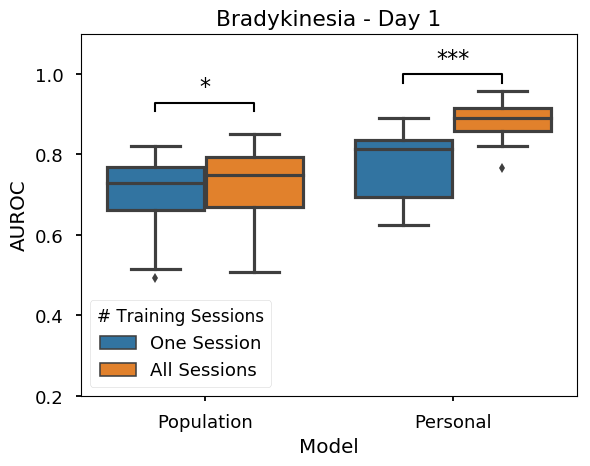

In [6]:
g1 = np.shape(global_one)[0]*['Population']
g2 = np.shape(person_one)[0]*['Personal']
df = pd.DataFrame.from_dict({'Model':(g1 + g2),'One Session':(list(global_one) + list(person_one)),
                             'All Sessions':(list(global_all) + list(person_all))})
df_new = pd.melt(df,id_vars=['Model'],value_vars=['One Session','All Sessions'],var_name=['# Training Sessions'])

figure = plt.figure()
figure.set_dpi(100)
figure.set_size_inches(6.4,4.8)
ax = sns.boxplot(x='Model',y='value',data=df_new,hue='# Training Sessions');
plt.ylabel('AUROC');
plt.title('Bradykinesia - Day 1');
plt.ylim(0.2,1.1);

x1,x2 = -0.2,0.2
y, h, col = df_new['value'].max() - 0.05, 0.02, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h+0.01, "*", ha='center', va='bottom', color=col,fontsize=16);

x3,x4 = 0.8,1.2
y, h, col = df_new['value'].max() + 0.02, 0.02, 'k'
plt.plot([x3, x3, x4, x4], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x3+x4)*.5, y+h+0.01, "***", ha='center', va='bottom', color=col,fontsize=16);

plt.savefig(os.path.join(results_path,'Bradykinesia Day 1 Comparison.tiff'),format='tiff',dpi=1000)
plt.savefig(os.path.join(results_path,'Bradykinesia Day 1 Comparison.png'),format='png',dpi=1000)

## Bradykinesia - Compare Day 2, 1 sessions and all sessions for training, test on remaining

In [7]:
global_one = np.load(os.path.join(results_path,'GLOB_brady_train1lovo.npy'))[1]
global_one = np.asarray(global_one)[~np.isnan(global_one)]
global_all = np.load(os.path.join(results_path,'GLOB_brady_train6lovo.npy'))[1]
global_all = np.asarray(global_all)[~np.isnan(global_all)]

person_one = np.load(os.path.join(results_path,'PERS_brady_train1lovo.npy'))[1]
person_one = np.asarray(person_one)[~np.isnan(person_one)]
person_all = np.load(os.path.join(results_path,'PERS_brady_train5lovo.npy'))[1]
person_all = np.asarray(person_all)[~np.isnan(person_all)]

_, pvalue1 = stats.ttest_rel(global_one,global_all)
_, pvalue2 = stats.ttest_rel(person_one,person_all)
print('Bradykinesia Day 2\n')
print('Population Model p-value: %f, mean improvement: %f'%(pvalue1,(np.nanmean(global_all) - np.nanmean(global_one))))
print('Personal Model p-value: %f, mean improvement: %f'%(pvalue2,(np.nanmean(person_all) - np.nanmean(person_one))))

Bradykinesia Day 2

Population Model p-value: 0.394027, mean improvement: 0.009822
Personal Model p-value: 0.123859, mean improvement: 0.041002


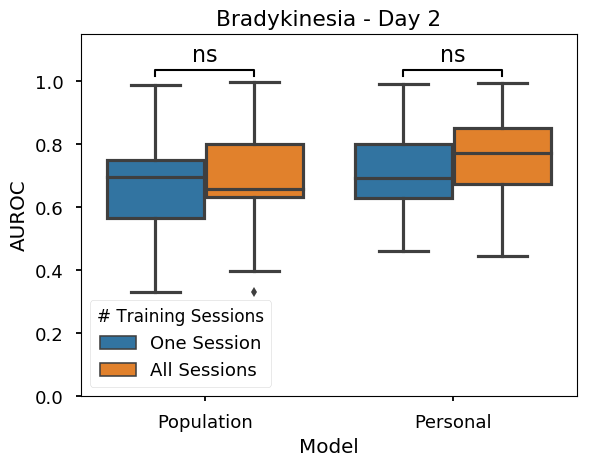

In [8]:
g1 = np.shape(global_one)[0]*['Population']
g2 = np.shape(person_one)[0]*['Personal']
df = pd.DataFrame.from_dict({'Model':(g1 + g2),'One Session':(list(global_one) + list(person_one)),
                             'All Sessions':(list(global_all) + list(person_all))})
df_new = pd.melt(df,id_vars=['Model'],value_vars=['One Session','All Sessions'],var_name=['# Training Sessions'])

figure = plt.figure()
figure.set_dpi(100)
figure.set_size_inches(6.4,4.8)
ax = sns.boxplot(x='Model',y='value',data=df_new,hue='# Training Sessions');
plt.ylabel('AUROC');
plt.title('Bradykinesia - Day 2');
plt.ylim(0,1.15);

x1,x2 = -0.2,0.2
y, h, col = df_new['value'].max() + 0.02, 0.02, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h+0.01, "ns", ha='center', va='bottom', color=col,fontsize=16);

x3,x4 = 0.8,1.2
y, h, col = df_new['value'].max() + 0.02, 0.02, 'k'
plt.plot([x3, x3, x4, x4], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x3+x4)*.5, y+h+0.01, "ns", ha='center', va='bottom', color=col,fontsize=16);

plt.savefig(os.path.join(results_path,'Bradykinesia Day 2 Comparison.tiff'),format='tiff',dpi=1000)
plt.savefig(os.path.join(results_path,'Bradykinesia Day 2 Comparison.png'),format='png',dpi=1000)

## Tremor - Compare Day 1, 1 sessions and all sessions for training, test on remaining

In [9]:
global_one = np.load(os.path.join(results_path,'GLOB_tremor_train1lovo.npy'))[0]
# global_one = np.asarray(global_one)[~np.isnan(global_one)]
global_all = np.load(os.path.join(results_path,'GLOB_tremor_train6lovo.npy'))[0]
# global_all = np.asarray(global_all)[~np.isnan(global_all)]

person_one = np.load(os.path.join(results_path,'PERS_tremor_train1lovo.npy'))[0]
# person_one = np.asarray(person_one)[~np.isnan(person_one)]
person_all = np.load(os.path.join(results_path,'PERS_tremor_train5lovo.npy'))[0]
# person_all = np.asarray(person_all)[~np.isnan(person_all)]

In [10]:
print(np.shape(person_one))
print(np.shape(person_all))
print(np.shape(global_one))
print(np.shape(global_all))

(16,)
(16,)
(19,)
(19,)


In [11]:
person_all = np.append(person_all,(np.nan,np.nan,np.nan))
person_one = np.append(person_one,(np.nan,np.nan,np.nan))

In [12]:
_, pvalue1 = stats.ttest_rel(global_one,global_all,nan_policy='omit')
_, pvalue2 = stats.ttest_rel(person_one,person_all,nan_policy='omit')
print('Tremor Day 1\n')
print('Population Model p-value: %f, mean improvement: %f'%(pvalue1,(np.nanmean(global_all) - np.nanmean(global_one))))
print('Personal Model p-value: %f, mean improvement: %f'%(pvalue2,(np.nanmean(person_all) - np.nanmean(person_one))))

Tremor Day 1

Population Model p-value: 0.000175, mean improvement: 0.029445
Personal Model p-value: 0.000340, mean improvement: 0.096639


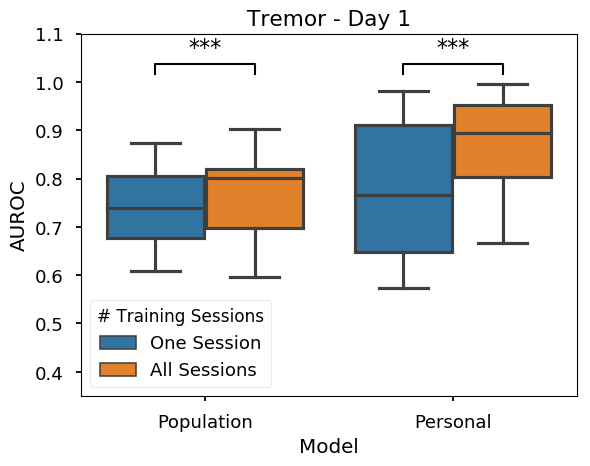

In [13]:
g1 = np.shape(global_one)[0]*['Population']
g2 = np.shape(person_one)[0]*['Personal']
df = pd.DataFrame.from_dict({'Model':(g1 + g2),'One Session':(list(global_one) + list(person_one)),
                             'All Sessions':(list(global_all) + list(person_all))})
df_new = pd.melt(df,id_vars=['Model'],value_vars=['One Session','All Sessions'],var_name=['# Training Sessions'])

figure = plt.figure()
figure.set_dpi(100)
figure.set_size_inches(6.4,4.8)
ax = sns.boxplot(x='Model',y='value',data=df_new,hue='# Training Sessions');
plt.ylabel('AUROC');
plt.title('Tremor - Day 1');
plt.ylim(0.35,1.1);

x1,x2 = -0.2,0.2
y, h, col = df_new['value'].max() + 0.02, 0.02, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h+0.01, "***", ha='center', va='bottom', color=col,fontsize=16);

x3,x4 = 0.8,1.2
y, h, col = df_new['value'].max() + 0.02, 0.02, 'k'
plt.plot([x3, x3, x4, x4], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x3+x4)*.5, y+h+0.01, "***", ha='center', va='bottom', color=col,fontsize=16);

plt.savefig(os.path.join(results_path,'Tremor Day 1 Comparison.tiff'),format='tiff',dpi=1000)
plt.savefig(os.path.join(results_path,'Tremor Day 1 Comparison.png'),format='png',dpi=1000)

## Tremor - Compare Day 2, 1 sessions and all sessions for training, test on remaining

In [14]:
global_one = np.load(os.path.join(results_path,'GLOB_tremor_train1lovo.npy'))[1]
# global_one = np.asarray(global_one)[~np.isnan(global_one)]
global_all = np.load(os.path.join(results_path,'GLOB_tremor_train6lovo.npy'))[1]
# global_all = np.asarray(global_all)[~np.isnan(global_all)]

person_one = np.load(os.path.join(results_path,'PERS_tremor_train1lovo.npy'))[1]
# person_one = np.asarray(person_one)[~np.isnan(person_one)]
person_all = np.load(os.path.join(results_path,'PERS_tremor_train5lovo.npy'))[1]
# person_all = np.asarray(person_all)[~np.isnan(person_all)]

In [15]:
print(np.shape(person_one))
print(np.shape(person_all))
print(np.shape(global_one))
print(np.shape(global_all))

(11,)
(11,)
(19,)
(19,)


In [16]:
person_all = np.append(person_all,(np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan))
person_one = np.append(person_one,(np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan))

In [17]:
_, pvalue1 = stats.ttest_rel(global_one,global_all,nan_policy='omit')
_, pvalue2 = stats.ttest_rel(person_one,person_all,nan_policy='omit')
print('Tremor Day 2\n')
print('Population Model p-value: %f, mean improvement: %f'%(pvalue1,(np.nanmean(global_all) - np.nanmean(global_one))))
print('Personal Model p-value: %f, mean improvement: %f'%(pvalue2,(np.nanmean(person_all) - np.nanmean(person_one))))

Tremor Day 2

Population Model p-value: 0.000385, mean improvement: 0.034584
Personal Model p-value: 0.210448, mean improvement: 0.057183


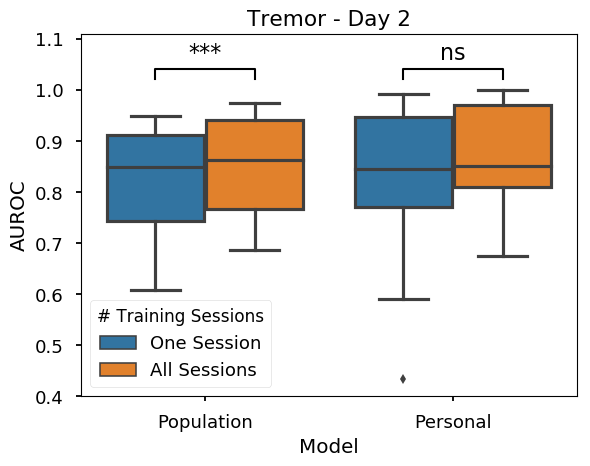

In [18]:
g1 = np.shape(global_one)[0]*['Population']
g2 = np.shape(person_one)[0]*['Personal']
df = pd.DataFrame.from_dict({'Model':(g1 + g2),'One Session':(list(global_one) + list(person_one)),
                             'All Sessions':(list(global_all) + list(person_all))})
df_new = pd.melt(df,id_vars=['Model'],value_vars=['One Session','All Sessions'],var_name=['# Training Sessions'])

figure = plt.figure()
figure.set_dpi(100)
figure.set_size_inches(6.4,4.8)
ax = sns.boxplot(x='Model',y='value',data=df_new,hue='# Training Sessions');
plt.ylabel('AUROC');
plt.title('Tremor - Day 2');
plt.ylim(0.4,1.11);

x1,x2 = -0.2,0.2
y, h, col = df_new['value'].max() + 0.02, 0.02, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h+0.01, "***", ha='center', va='bottom', color=col,fontsize=16);

x3,x4 = 0.8,1.2
y, h, col = df_new['value'].max() + 0.02, 0.02, 'k'
plt.plot([x3, x3, x4, x4], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x3+x4)*.5, y+h+0.01, "ns", ha='center', va='bottom', color=col,fontsize=16);

plt.savefig(os.path.join(results_path,'Tremor Day 2 Comparison.tiff'),format='tiff',dpi=1000)
plt.savefig(os.path.join(results_path,'Tremor Day 2 Comparison.png'),format='png',dpi=1000)

## Sensor Analysis

In [ ]:
# filename = 'Features_AllLocs_HP+LP_GyroLP.h5'
filename = 'Features_AllLocs_HP.h5'
Data = pd.read_hdf(os.path.join(features_path,filename))
print(Data.shape)

In [ ]:
#filter empty rows on all locations
for s in Data.columns.values[7:]:
    print('%s,discarded %d rows'%(s,sum(Data[s].apply(type) == float)))
    Data = Data[Data[s].apply(type) != float]
    
print(Data.shape)

In [ ]:
def featureUnpack(Data, sensor_list):
    #unpack features
    colnames=['RMSX', 'RMSY', 'RMSZ', 'rangeX', 'rangeY', 'rangeZ', 'meanX',
           'meanY', 'meanZ', 'varX', 'varY', 'varZ', 'skewX', 'skewY', 'skewZ',
           'kurtX', 'kurtY', 'kurtZ', 'xcor_peakXY', 'xcorr_peakXZ',
           'xcorr_peakYZ', 'xcorr_lagXY', 'xcorr_lagXZ', 'xcorr_lagYZ', 'Dom_freq',
           'Pdom_rel', 'PSD_mean', 'PSD_std', 'PSD_skew', 'PSD_kur', 'jerk_mean',
           'jerk_std', 'jerk_skew', 'jerk_kur', 'Sen_X', 'Sen_Y', 'Sen_Z']

    colnames1=[i+'acc' for i in colnames]
    colnames2=[i+'gyr' for i in colnames]
    colnames=colnames1+colnames2
    
    Datafinal = pd.DataFrame()

    for i in range(len(Data)):
        Datatemp=pd.DataFrame()
        for sensors in sensor_list:
            if sensors!="flexor_digitorum_":
                F1 = Data[sensors + '_accel'].iloc[i]
                F2 = Data[sensors + '_gyro'].iloc[i]
                F = pd.DataFrame(data=np.hstack((F1,F2)).reshape(-1,1).T,index=[i],columns=[i+'_'+sensors for i in colnames])
                Datatemp=pd.concat((Datatemp,F),axis=1)
            else:
                F1 = Data[sensors + '_accel'].iloc[i]
                F = pd.DataFrame(data=F1.reshape(-1,1).T,index=[i],columns=[i+'_'+sensors for i in colnames1])
                Datatemp=pd.concat((Datatemp,F),axis=1)
        Datafinal = pd.concat((Datafinal,Datatemp),axis=0)
        
    Datafinal=Datafinal.reset_index(drop=True)
    Data=Data.reset_index(drop=True)
    Datafinal = pd.concat((Data.iloc[:,:7],Datafinal),axis=1)
        
    return Datafinal

In [ ]:
# sensor_list = ['anterior_thigh_','dorsal_hand_','sacrum']
sensor_list = [['dorsal_hand_'],['flexor_digitorum_'],
               ['anterior_thigh_'],['dorsal_hand_','flexor_digitorum_','anterior_thigh_']] # just hand sensors

In [ ]:
# symptom = 'Bradykinesia'
symptom = 'Tremor'
res_all = pd.DataFrame()

fileNameList = ['Hand', 'Forearm', 'Thigh', 'Combo']
AX = None

for x,sList in zip(range(len(sensor_list)),sensor_list):
    SData = featureUnpack(Data,sList)
    
    X = SData.iloc[:,7:].as_matrix()
    fnames = SData.iloc[:,7:].columns.values

    indp = ((SData[symptom]>0))
    indp = indp.values
    y = indp.astype(int) #target 
    print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

    models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
    model_name = ['Random Forest']
    models = list(zip(models,model_name))
    groups = SData.Subject.as_matrix()

    res,res_group = LOSOCV(SData,X,y,groups,models)
    res_all = pd.concat((res_all,res))
    
    AUC = res_group['Random Forest']['auroc']
    
    
    save_object(res_group,symptom+fileNameList[x]+'DataResults')
    
    T = 'Random Forest'
    NanInds = []
    for i in range(len(res_group[T]['auroc'])):
        if np.isnan(res_group[T]['auroc'][i]):
            NanInds.append(i)
    for i in sorted(NanInds,reverse=True):
        del res_group[T]['tpr'][i]
        del res_group[T]['auroc'][i]
    
    print(fileNameList[x],np.mean(AUC),
          stats.t.interval(.95,len(AUC)-1, loc=np.mean(AUC), scale=stats.sem(AUC)))
    
    cols = ['b','r','g','m','k']
    
    if AX==None:
        AX = plot_roc(res_group['Random Forest']['tpr'], res_group['Random Forest']['fpr'][0], 
                      np.nanmean(res_group['Random Forest']['auroc']),plotname=fileNameList[x],col=cols[x])
    else:
        plot_roc(res_group['Random Forest']['tpr'], res_group['Random Forest']['fpr'][0], 
                      np.nanmean(res_group['Random Forest']['auroc']),ax=AX,plotname=fileNameList[x],col=cols[x])
        
plt.savefig(symptom+'SensorsRF.tiff',format='tiff',dpi=1000)
plt.savefig(symptom+'SensorsRF.png',format='png',dpi=1000)